In [93]:
import keras
from keras import optimizers
from keras import losses
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Dropout, Embedding, LSTM
from tensorflow.keras.optimizers import RMSprop, Adam, Nadam
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras import regularizers

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import tensorflow 
import sys
print("Python: ", sys.version)

print("pandas: ", pd.__version__)
print("numpy: ", np.__version__)
print("seaborn: ", sns.__version__)
print("matplotlib: ", matplotlib.__version__)
print("sklearn: ", sklearn.__version__)
print("Keras: ", keras.__version__)
print("Tensorflow: ", tensorflow.__version__)



Python:  3.9.5 | packaged by conda-forge | (default, Jun 19 2021, 00:24:55) 
[Clang 11.1.0 ]
pandas:  1.4.1
numpy:  1.23.3
seaborn:  0.11.2
matplotlib:  3.5.1
sklearn:  1.0.2
Keras:  2.8.0
Tensorflow:  2.8.0


In [94]:
class Visualization:
    labels = ["Normal", "Anomaly"]

    def draw_confusion_matrix(self, y, ypred):
        matrix = confusion_matrix(y, ypred)

        plt.figure(figsize=(10, 8))
        colors=[ "orange","green"]
        sns.heatmap(matrix, xticklabels=self.labels, yticklabels=self.labels, cmap=colors, annot=True, fmt="d")
        plt.title("Confusion Matrix")
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()


    def draw_anomaly(self, y, error, threshold):
        groupsDF = pd.DataFrame({'error': error,
                                 'true': y}).groupby('true')

        figure, axes = plt.subplots(figsize=(12, 8))

        for name, group in groupsDF:
            axes.plot(group.index, group.error, marker='x' if name == 1 else 'o', linestyle='',
                    color='r' if name == 1 else 'g', label="Anomaly" if name == 1 else "Normal")

        axes.hlines(threshold, axes.get_xlim()[0], axes.get_xlim()[1], colors="b", zorder=100, label='Threshold')
        axes.legend()
        
        plt.title("Anomalies")
        plt.ylabel("Error")
        plt.xlabel("Data")
        plt.show()

    def draw_error(self, error, threshold):
            plt.plot(error, marker='o', ms=3.5, linestyle='',
                     label='Point')

            plt.hlines(threshold, xmin=0, xmax=len(error)-1, colors="b", zorder=100, label='Threshold')
            plt.legend()
            plt.title("Reconstruction error")
            plt.ylabel("Error")
            plt.xlabel("Data")
            plt.show()


In [95]:
##filePath = './data/creditcardanomalydetection.csv'
filePath = './dataset/creditcard.csv'
df = pd.read_csv(filepath_or_buffer=filePath, header=0, sep=',')
print(df.shape[0])
df.head()


284807


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [96]:
df['Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1, 1))
df0 = df.query('Class == 0').sample(20000)
df1 = df.query('Class == 1').sample(400)
df = pd.concat([df0, df1])

In [103]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(labels=['Time', 'Class'], axis = 1) , 
                                                    df['Class'], test_size=0.2, random_state=42)
print(x_train.shape, 'train samples')
print(x_test.shape, 'test samples')


(16320, 29) train samples
(4080, 29) test samples


In [104]:
#simple autoencoder
logfilename = "simpleautoencoder"

encoding_dim = 12
input_dim = x_train.shape[1]

inputArray = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(inputArray)

decoded = Dense(input_dim, activation='softmax')(encoded)

autoencoder = Model(inputArray, decoded)
autoencoder.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 29)]              0         
                                                                 
 dense_50 (Dense)            (None, 12)                360       
                                                                 
 dense_51 (Dense)            (None, 29)                377       
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


In [105]:
#sparse autoencoder
# logfilename = "sparseautoencoder"

# encoding_dim = 12
# input_dim = x_train.shape[1]

# inputArray = Input(shape=(input_dim,))
# encoded = Dense(encoding_dim, activation='relu',
#                activity_regularizer=regularizers.l1(10e-5))(inputArray)

# decoded = Dense(input_dim, activation='softmax')(encoded)

# autoencoder = Model(inputArray, decoded)
# autoencoder.summary()


In [106]:
#deep autoencoder

# logfilename = "deepautoencoder"

# encoding_dim = 16
# input_dim = x_train.shape[1]

# inputArray = Input(shape=(input_dim,))
# encoded = Dense(encoding_dim, activation='relu')(inputArray)
# encoded = Dense(8, activation='relu')(encoded)
# encoded = Dense(4, activation='relu')(encoded)

# decoded = Dense(8, activation='relu')(encoded)
# decoded = Dense(encoding_dim, activation='relu')(decoded)
# decoded = Dense(input_dim, activation='softmax')(decoded)

# autoencoder = Model(inputArray, decoded)
# autoencoder.summary()


In [107]:
autoencoder.compile(optimizer=RMSprop(), 
                    loss='mean_squared_error',
                    metrics=['mae', 'accuracy'])

In [109]:
batch_size = 32
epochs = 20

history = autoencoder.fit(x_train, x_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    shuffle=True,
                    validation_data=(x_test, x_test),
                    callbacks=[TensorBoard(log_dir='./logs/{0}'.format(logfilename))])


Epoch 1/20
510/510 [==============================] - 3s 5ms/step - loss: 1.3855 - mae: 0.6511 - accuracy: 0.8164 - val_loss: 1.5615 - val_mae: 0.6637 - val_accuracy: 0.8167
Epoch 2/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3854 - mae: 0.6511 - accuracy: 0.8180 - val_loss: 1.5613 - val_mae: 0.6637 - val_accuracy: 0.8228
Epoch 3/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3853 - mae: 0.6511 - accuracy: 0.8176 - val_loss: 1.5612 - val_mae: 0.6637 - val_accuracy: 0.8213
Epoch 4/20
510/510 [==============================] - 3s 6ms/step - loss: 1.3852 - mae: 0.6511 - accuracy: 0.8195 - val_loss: 1.5611 - val_mae: 0.6637 - val_accuracy: 0.8233
Epoch 5/20
510/510 [==============================] - 3s 5ms/step - loss: 1.3851 - mae: 0.6511 - accuracy: 0.8234 - val_loss: 1.5610 - val_mae: 0.6637 - val_accuracy: 0.8250
Epoch 6/20
510/510 [==============================] - 3s 5ms/step - loss: 1.3851 - mae: 0.6511 - accuracy: 0.8240 - val_loss: 1.56

In [110]:
score = autoencoder.evaluate(x_test, x_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

128/128 [==============================] - 1s 4ms/step - loss: 1.5607 - mae: 0.6636 - accuracy: 0.8338
Test loss: 1.5606781244277954
Test accuracy: 0.663619875907898


In [111]:
threshold=15.00
y_pred = autoencoder.predict(x_test)
y_dist = np.linalg.norm(x_test - y_pred, axis=-1)
z = zip(y_dist >= threshold, y_dist)
y_label=[]
error = []
for idx, (is_anomaly, y_dist) in enumerate(z):
    if is_anomaly:
        y_label.append(1)
    else:
        y_label.append(0)
    error.append(y_dist)



2022-10-08 18:16:38.259036: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [112]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.59      0.61      0.60        93

    accuracy                           0.98      4080
   macro avg       0.79      0.80      0.80      4080
weighted avg       0.98      0.98      0.98      4080



In [87]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.52      0.56      0.54        93

    accuracy                           0.98      4080
   macro avg       0.75      0.77      0.76      4080
weighted avg       0.98      0.98      0.98      4080



In [88]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.52      0.56      0.54        93

    accuracy                           0.98      4080
   macro avg       0.75      0.77      0.76      4080
weighted avg       0.98      0.98      0.98      4080



In [89]:
print(classification_report(y_test,y_label))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3987
           1       0.52      0.56      0.54        93

    accuracy                           0.98      4080
   macro avg       0.75      0.77      0.76      4080
weighted avg       0.98      0.98      0.98      4080



In [90]:
roc_auc_score(y_test, y_label)

0.7735503288914779

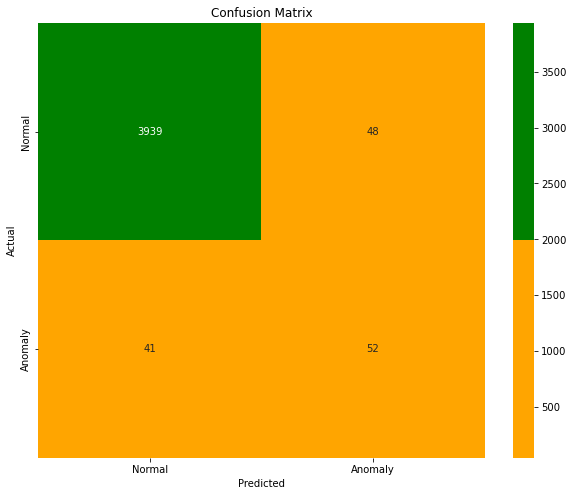

In [91]:
viz = Visualization()

viz.draw_confusion_matrix(y_test, y_label)

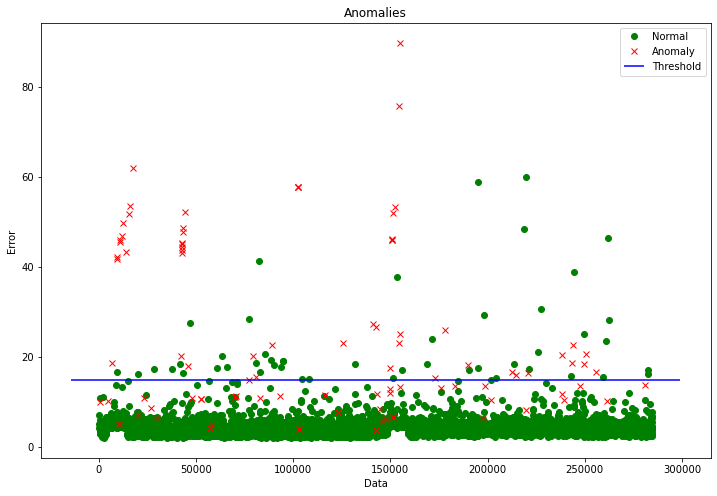

In [92]:
viz.draw_anomaly(y_test, error, threshold)